In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

# Enable Arabic text in matplotlib
plt.rcParams['font.family'] = 'Arial'

# Read the dataset
df = pd.read_csv('/kaggle/input/asocciion/Clean_Dataset.csv')


In [5]:
# Create transactions-like data
def prepare_transactions():
    transactions = df.apply(lambda row: {
        f"airline_{row['airline']}", 
        f"class_{row['class']}", 
        f"stops_{row['stops']}", 
        f"source_{row['source_city']}", 
        f"dest_{row['destination_city']}",
        f"departure_{row['departure_time']}",
        f"arrival_{row['arrival_time']}"
    }, axis=1).tolist()
    return transactions

In [6]:
def plot_top_items(transactions, n=10):
    all_items = [item for transaction in transactions for item in transaction]
    item_counts = Counter(all_items)
    top_items = item_counts.most_common(n)
    
    items, counts = zip(*top_items)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(items), palette='viridis')
    plt.xlabel('عدد مرات التكرار')
    plt.ylabel('العناصر')
    plt.title('أكثر 10 عناصر تكراراً في الرحلات')
    plt.tight_layout()
    plt.show()  # عرض الرسم
    return dict(top_items)

In [7]:
def plot_transaction_distribution(transactions):
    transaction_lengths = [len(t) for t in transactions]
    plt.figure(figsize=(10, 6))
    sns.histplot(transaction_lengths, bins=range(1, max(transaction_lengths)+2), kde=True, color='skyblue')
    plt.xlabel('عدد العناصر في الرحلة')
    plt.ylabel('عدد الرحلات')
    plt.title('توزيع عدد العناصر في الرحلات')
    plt.tight_layout()
    plt.show()  # عرض الرسم

def plot_price_analysis():
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price'], bins=50)
    plt.title('توزيع أسعار الرحلات')
    plt.xlabel('السعر')
    plt.ylabel('عدد الرحلات')
    plt.show()  # عرض الرسم

In [8]:
def plot_association_rules(rules):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=rules, x="support", y="confidence", 
                   size="lift", hue="lift", palette="cool", 
                   sizes=(40, 400))
    plt.title("قواعد الترابط: الدعم مقابل الثقة")
    plt.xlabel("الدعم")
    plt.ylabel("الثقة")
    plt.grid(True)
    plt.show()  # عرض الرسم

def recommend_flights(features, rules):
    recommendations = set()
    features_set = set(features)
    for _, row in rules.iterrows():
        if row['antecedents'].issubset(features_set):
            recommendations |= row['consequents']
    return recommendations

بدء التحليل...

تحليل العناصر الأكثر تكراراً...


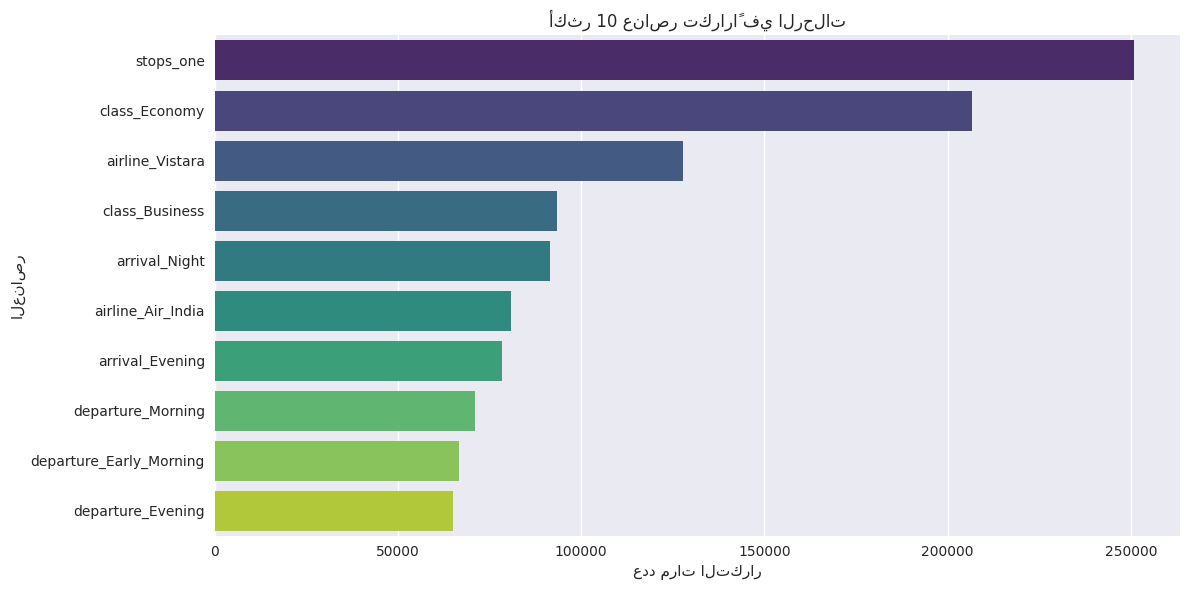


أكثر 10 عناصر تكراراً:
stops_one: 250863
class_Economy: 206666
airline_Vistara: 127859
class_Business: 93487
arrival_Night: 91538
airline_Air_India: 80892
arrival_Evening: 78323
departure_Morning: 71146
departure_Early_Morning: 66790
departure_Evening: 65102

تحليل توزيع العناصر في الرحلات...


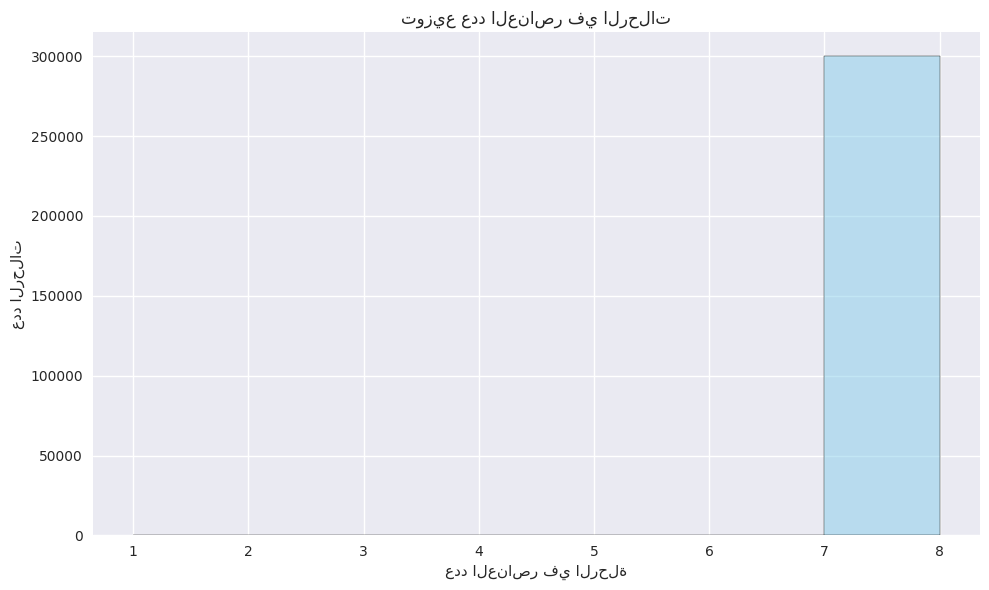


تحضير البيانات لتحليل Apriori...

توليد قواعد الترابط...

إنشاء الرسومات البيانية...


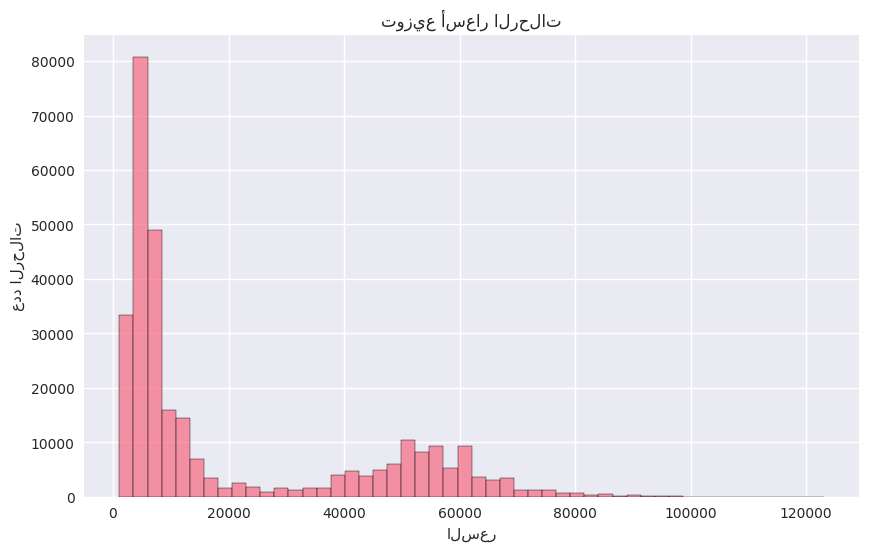

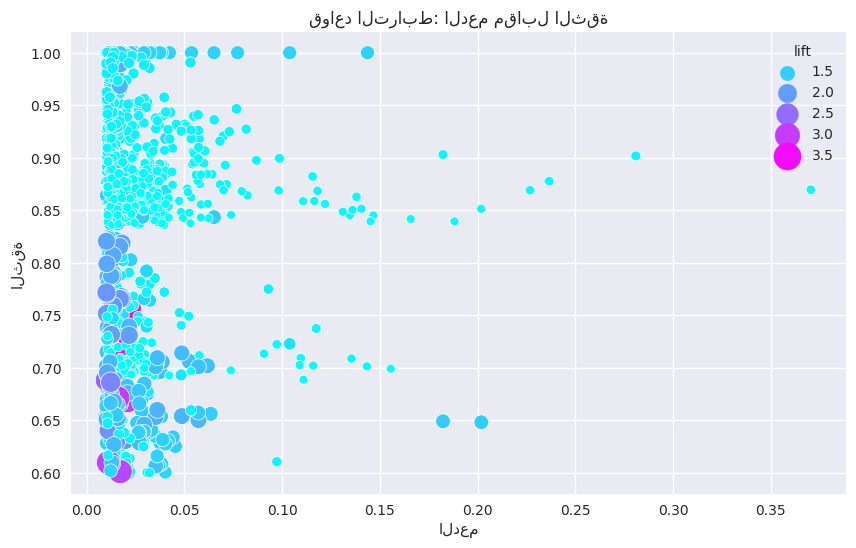


أفضل 5 قواعد ترابط:
                                            antecedents  \
348               (stops_zero, departure_Early_Morning)   
1216  (stops_zero, departure_Early_Morning, class_Ec...   
1217       (stops_zero, arrival_Morning, class_Economy)   
349                       (stops_zero, arrival_Morning)   
1584     (airline_Indigo, departure_Evening, stops_one)   

                         consequents   support  confidence      lift  
348                (arrival_Morning)  0.020813    0.756295  3.618464  
1216               (arrival_Morning)  0.015705    0.721899  3.453895  
1217       (departure_Early_Morning)  0.015705    0.671128  3.016035  
349        (departure_Early_Morning)  0.020813    0.668987  3.006415  
1584  (arrival_Night, class_Economy)  0.011174    0.609707  2.927479  

مثال على التوصيات:
التوصيات للرحلة مع الخصائص {'source_Delhi', 'airline_SpiceJet', 'class_Economy'}:
{'stops_one', 'class_Economy'}


In [9]:
def main():
    print("بدء التحليل...")
    
    transactions = prepare_transactions()
    
    print("\nتحليل العناصر الأكثر تكراراً...")
    top_items = plot_top_items(transactions)
    print("\nأكثر 10 عناصر تكراراً:")
    for item, count in top_items.items():
        print(f"{item}: {count}")
    
    print("\nتحليل توزيع العناصر في الرحلات...")
    plot_transaction_distribution(transactions)
    
    print("\nتحضير البيانات لتحليل Apriori...")
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
    print("\nتوليد قواعد الترابط...")
    frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    rules = rules[rules['lift'] >= 1]
    
    rules.to_csv('association_rules.csv', index=False)
    frequent_itemsets.to_csv('frequent_itemsets.csv', index=False)
    
    print("\nإنشاء الرسومات البيانية...")
    plot_price_analysis()
    plot_association_rules(rules)
    
    print("\nأفضل 5 قواعد ترابط:")
    top_rules = rules.sort_values('lift', ascending=False).head()
    print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
    
    print("\nمثال على التوصيات:")
    example_features = {'airline_SpiceJet', 'class_Economy', 'source_Delhi'}
    recommendations = recommend_flights(example_features, rules)
    print(f"التوصيات للرحلة مع الخصائص {example_features}:")
    print(recommendations)

if __name__ == "__main__":
    main()